In [1]:
import time
import numpy as np
import pandas as pd
import hist as hist2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep

In [2]:
! ls

R_edges.pkl       __pycache__       edge_index.pkl
Rscores.pkl       batch_x.pkl       particlenet.ipynb


In [3]:
import pickle as pkl

with open('batch_x.pkl', 'rb') as handle:
    batch_x = pkl.load(handle)
with open('Rscores.pkl', 'rb') as handle:
    Rscores = pkl.load(handle).detach()
with open('R_edges.pkl', 'rb') as handle:
    R_edges = pkl.load(handle)    
with open('edge_index.pkl', 'rb') as handle:
    edge_index_dic = pkl.load(handle)

In [4]:
edge_index_dic.keys()

dict_keys(['edge_conv_0', 'edge_conv_1', 'edge_conv_2'])

FileNotFoundError: [Errno 2] No such file or directory: '/Users/fmokhtar/Desktop/xai/edge_conv_0.pdf'

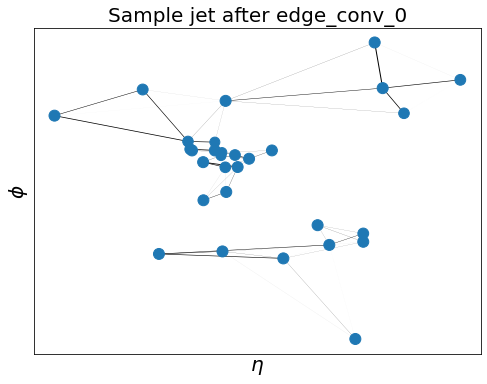

In [5]:
# https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html
import networkx as nx
import torch
import torch_geometric
import numpy as np

num_nodes = len(Rscores)

# Get positions of nodes in the graph
# recall: Features, in order: [eta, phi, pt, mask].
eta = batch_x[:, 0]
phi = batch_x[:, 1]
pt = np.abs(batch_x[:, 2])

eta_phi = batch_x[:, :2]

pos = {}
for node_i in range(num_nodes):
    pos[node_i] = eta_phi.numpy()[node_i]

to_undirected = True
for edgeconv in ['edge_conv_0', 'edge_conv_1', 'edge_conv_2']:
    # if directed
    if to_undirected == False:
        edge_index, edge_weight = edge_index_dic[edgeconv].detach(), torch.abs(R_edges[edgeconv]).sum(axis=1).detach()

    # if undirected
    else:
        edge_index, edge_weight = torch_geometric.utils.to_undirected(edge_index_dic[edgeconv].detach(), torch.abs(R_edges[edgeconv].detach()).sum(axis=1))

    data = torch_geometric.data.Data(edge_index=edge_index, edge_weight=edge_weight, num_nodes=num_nodes)
    G = torch_geometric.utils.to_networkx(data, to_undirected=to_undirected)

    fig, ax = plt.subplots(figsize=(8, 6))
    nx.draw_networkx(G, pos, node_size=250*pt, with_labels=False, width=edge_weight/edge_weight.max(), ax=ax)   
    ax.set_xlabel(r"$\eta$", fontsize=20)
    ax.set_ylabel(r"$\phi$", fontsize=20);
    ax.set_title(f'Sample jet after {edgeconv}', fontsize=20);
    plt.savefig(f'/Users/fmokhtar/Desktop/xai/{edgeconv}.pdf')

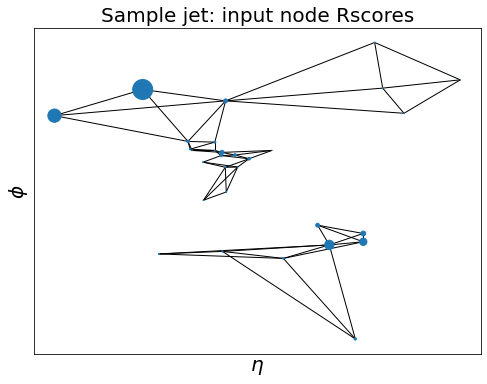

In [247]:
# https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html
import networkx as nx
import torch
import torch_geometric
import numpy as np

to_undirected = True
# if directed
if to_undirected == False:
    edge_index, edge_weight = edge_index_dic['edge_conv_0'].detach()

# if undirected
else:
    edge_index = torch_geometric.utils.to_undirected(edge_index_dic['edge_conv_0'].detach())

data = torch_geometric.data.Data(edge_index=edge_index, num_nodes=num_nodes)
G = torch_geometric.utils.to_networkx(data, to_undirected=to_undirected)

fig, ax = plt.subplots(figsize=(8, 6))
nx.draw_networkx(G, pos, node_size=400*torch.abs(Rscores).sum(axis=1)/torch.abs(Rscores).sum(axis=1).max(), with_labels=False, ax=ax)   
ax.set_xlabel(r"$\eta$", fontsize=20)
ax.set_ylabel(r"$\phi$", fontsize=20);
ax.set_title(f'Sample jet: input node Rscores', fontsize=20);